In [1]:
# import computational packages
import numpy as np
import pandas as pd 

# sparse matrix
from scipy.io import mmread

# import modeling packages
from scipy.stats import chi2, nbinom
from scipy.optimize import minimize

# parallelizing
from multiprocessing import Pool

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white');
%config InlineBackend.figure_format='retina'

In [2]:
def get_input_and_output_vectors(spacer_sequence, proximal_genes):
    '''helper function to get input and output vectors'''

    # get input and output vectors as series (for merging)
    input_series = cell_guide_matrix.loc[spacer_sequence]
    output_series = count_matrix_df.loc[proximal_genes]
    
    # filter output series to only include cells in input vector
    output_series = output_series[output_series.index.isin(input_series.index)]
    
    # get input and output vectors as np.arrays (for faster computation)
    input_vector = input_series.values
    output_vector = output_series.values
    
    return input_vector, output_vector

In [3]:
def divide_by_guide(input_vector, divide_vector):
    '''divide a given divide vector based on an input vector'''
    
    # split divide vector based on guide presence
    cells_with_guide = divide_vector[input_vector.astype(bool)]
    cells_wo_guide = divide_vector[~input_vector.astype(bool)]
    
    return cells_with_guide, cells_wo_guide

In [4]:
def nbinom_ll(params, x, counts, s, s_scores, g2m_scores):
    '''
    this function calculates the log-likelihood for the alternative hypothesis
    alternative hypothesis - beta1 != 0 
    params[0] = beta0 (intercept term)
    params[1] = beta1 (guide effect size)
    params[2] = sqrt(disperion)
    params[3] = beta2 for cell cycle s phase score
    params[4] = beta3 for cell cycle g2m phase score
    x1 = indicator vector
    counts = vector of counts for UMIs of a gene in each cell
    s = scaling factor
    '''
    
    # calculate value for dispersion of negative binomial distribution
    disp = params[2] ** 2
    
    # calculate mu for negative binomial distribution
    mu = np.exp(params[0] + x * params[1] + params[3] * s_scores + 
                params[4] * g2m_scores + np.log(s))
    
    # calculate probability value for negative binomial distribution
    prob = disp / (disp + mu)
    
    # calculate log-likelihood vector for observed counts
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    
    # take sum of log likelihood vector
    return -ll.sum()

In [5]:
def null_ll(params, counts, s, s_scores, g2m_scores):
    '''
    this function calculates the log-likelihood for the null hypothesis
    null hypothesis - beta1 == 0 
    params[0] = beta0 (intercept term)
    params[1] = sqrt(dispersion)
    params[2] = beta2 for cell cycle s phase score
    params[3] = beta3 for cell cycle g2m phase score
    counts = vector of counts for UMIs of a gene in each cell
    s = scaling factor
    '''
    
    # calculate value for dispersion of negative binomial distribution
    disp = params[1] ** 2
    
    # calculate mu for negative binomial distribution 
    mu = np.exp(params[0] + params[2] * s_scores + params[3] * g2m_scores + 
                np.log(s))
    
    # calculate probability value for negative binomial distribution
    prob = disp / (disp + mu)
    
    # calculate log-likelihood vector for observed counts
    ll = nbinom.logpmf(counts, n=disp, p=prob)
    
    # take sum of log-likelihood vector
    return -ll.sum()

In [6]:
def write_success_output(spacer_sequence, proximal_genes, null, alt):
    '''write model information if both optimizations successful'''
    
    # get null GLM information as a list
    null_coeffs = [str(x) for x in null.x]
    null_function = str(null.fun)
    
    # get alternative GLM information as a list
    alt_coeffs = [str(x) for x in alt.x]
    alt_function = str(alt.fun)
    
    # create list of output information and convert to comma separated string
    output_list = [proximal_genes, spacer_sequence] + null_coeffs + \
                  [null_function] + alt_coeffs + [alt_function]
    output_string = ','.join(output_list)
    print(output_string)
    
    return True

In [7]:
def write_error_output(spacer_sequence, proximal_genes):
    '''write guide and gene information if one or both optimizations failed'''
    
    # create error string and write to error file 
    error_list = [proximal_genes, spacer_sequence, 'optimization failed']
    error_string = ','.join(error_list)
    print(error_string)
    
    return True

In [8]:
def run_likelihood_ratio_test(null_function, alt_function):
    '''helper function to run likelihood test'''
    
    # negate function outputs to get null and alternative likelihood
    null_likelihood = -1 * null_function
    alt_likelihood = -1 * alt_function
    
    # calculate test statistic and p-value
    ts = -2 * (null_likelihood - alt_likelihood)
    pval = 1 - chi2.cdf(ts, 1)
    
    # return p-value
    return pval

In [9]:
def get_iter_coeffs_null(fun):
    output_10000_iters_null.append(fun)
    
def get_iter_coeffs_alt(fun):
    output_10000_iters_alt.append(fun)

In [10]:
def run_glm_optimizer(spacer_sequence, proximal_genes, max_iters):
    '''function to fit null and alternative models for given guide-gene pair'''

    # get input and output vectors
    input_vector, output_vector = get_input_and_output_vectors(spacer_sequence, 
                                                               proximal_genes)

    # get subsets of output vector based on guide presence in cells
    cells_with_guide, cells_wo_guide = divide_by_guide(input_vector, 
                                                       output_vector)
    
    # get subsets of scaling factors based on guide presence in cells
    scalers_with_guide, scalers_wo_guide = divide_by_guide(input_vector, 
                                                            scalers_arr)

    # calculate initial parameter estimates
    beta0_estimate = np.mean(np.log(cells_wo_guide + 1) - \
                             np.log(scalers_wo_guide))
    disp_estimate = beta0_estimate - np.mean(np.log(cells_with_guide + 1) - \
                                             np.log(scalers_with_guide))
    
    # fit null model using scipy optimizer
    null = minimize(null_ll, x0=(beta0_estimate, disp_estimate, 0, 0), 
                    args=(output_vector, scalers_arr, 
                          cell_s_scores, cell_g2m_scores),
                    method='Nelder-Mead', 
                    options={'maxiter': max_iters, 'maxfev': max_iters})
    
    # fit alternative model using scipy optimizer
    alt = minimize(nbinom_ll, x0=(null.x[0], 0, null.x[1], 0, 0), 
                   args=(input_vector, output_vector, 
                         scalers_arr, cell_s_scores, cell_g2m_scores),
                   method='Nelder-Mead', 
                   options={'maxiter': max_iters, 'maxfev': max_iters})
    
    # if both optimizations run successfully
    if null.success and alt.success:
        
        # print successful output
        print('successful output!')
        
        # write model information to results file
        write_success_output(spacer_sequence, proximal_genes, null, alt)
        
        # perform likelihood ratio test and return p-value
        pval = run_likelihood_ratio_test(null.fun, alt.fun)
        
        return pval
    
    
    # if one or both of the optimizations fail
    else:
        
        # print error output
        print('error output')
        
        # write guide-gene info to error file
        write_error_output(spacer_sequence, proximal_genes)
        
        # return np.nan as a placeholder
        return np.nan

In [11]:
# read in scaling factors
print('reading in scaling factors...')
scaling_factors = pd.read_csv('/iblm/netapp/home/karthik/gasperini_project/data/scaling_factors.csv')
scaling_factors.columns = ['cell', 'scaling_factor']
scaling_factors = scaling_factors.set_index('cell')

reading in scaling factors...


In [12]:
# read in cell-guide matrix
print('loading in cell-guide matrix...')
cell_guide_matrix = pd.read_hdf('/iblm/netapp/home/karthik/gasperini_project/data/cell_guide_matrix.h5')

loading in cell-guide matrix...


In [13]:
cell_guide_matrix

cell,AAACCTGAGAGGTACC-1_1A_1_SI-GA-E2,AAACCTGAGTCAATAG-1_1A_1_SI-GA-E2,AAACCTGCAAACAACA-1_1A_1_SI-GA-E2,AAACCTGCACTTCTGC-1_1A_1_SI-GA-E2,AAACCTGCATGTAGTC-1_1A_1_SI-GA-E2,AAACCTGGTAGCGCAA-1_1A_1_SI-GA-E2,AAACCTGGTAGGGACT-1_1A_1_SI-GA-E2,AAACCTGGTATATGAG-1_1A_1_SI-GA-E2,AAACCTGGTCAAAGCG-1_1A_1_SI-GA-E2,AAACCTGGTCTTCAAG-1_1A_1_SI-GA-E2,...,TTTGTCACAACGATGG-1_2B_8_SI-GA-H9,TTTGTCACACTTCTGC-1_2B_8_SI-GA-H9,TTTGTCACAGATAATG-1_2B_8_SI-GA-H9,TTTGTCACAGCCAGAA-1_2B_8_SI-GA-H9,TTTGTCACATTAGGCT-1_2B_8_SI-GA-H9,TTTGTCAGTACCTACA-1_2B_8_SI-GA-H9,TTTGTCAGTATCACCA-1_2B_8_SI-GA-H9,TTTGTCAGTTCAGACT-1_2B_8_SI-GA-H9,TTTGTCAGTTCTGTTT-1_2B_8_SI-GA-H9,TTTGTCATCAAAGTAG-1_2B_8_SI-GA-H9
AGAAAGCTCCTCCAGTTCAC,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGATCGCTTTGACTGTGACA,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACAATAAAGAACAGAACACA,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTAAATTGAGACCTCAGGAG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCTTCCCCCCACCAATAACA,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCCTCCCCACGGCCACCAGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCCTTCCCCTCAGTACACCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACATGCTGTTTCCAGAGCAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CTTCTTCCACAAGAAGACAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# filter scaling factors to only include cells in cell-guide matrix
print('creating scaling factors array (for computation)...')
scaling_factors = scaling_factors.merge(cell_guide_matrix.iloc[0], on='cell')
scaling_factors = scaling_factors.iloc[:, 0]
scaling_factors_arr = scaling_factors.values # np.array for faster computation
scalers_arr = scaling_factors_arr

creating scaling factors array (for computation)...


In [15]:
# read in UMI count matrix
print('reading in count matrix...')
count_matrix = mmread('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.exprs.mtx')
count_matrix_df = pd.DataFrame(count_matrix.toarray())

reading in count matrix...


In [16]:
# read in column names from corresponding cells file
colnames = []
with open('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.cells.txt') as f:
    colnames = f.readlines()
colnames = pd.Series(colnames).str.strip()

# read in index (row names) from corresponding genes file 
rownames = []
with open('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.genes.txt') as f:
    rownames = f.readlines()
rownames = pd.Series(rownames).str.strip()

# assign row and column names to UMI count matrix
count_matrix_df.index = rownames
count_matrix_df.columns = colnames

In [17]:
# read in cell cycle scores and merge into single dataframe
s_scores = pd.read_csv('./../data/s_scores.csv', index_col=0)
g2m_scores = pd.read_csv('./../data/g2m_scores.csv', index_col=0)
s_scores.index = s_scores.index.rename('cell')
g2m_scores.index = g2m_scores.index.rename('cell')
merged_cell_cycle_scores = pd.merge(s_scores, g2m_scores, on='cell')
merged_cell_cycle_scores = merged_cell_cycle_scores[merged_cell_cycle_scores.index.isin(cell_guide_matrix.columns)]
merged_cell_cycle_scores.head()
cell_s_scores = merged_cell_cycle_scores['S.Score']
cell_g2m_scores = merged_cell_cycle_scores['G2M.Score']

In [18]:
# read in index (row names) from corresponding genes file 
rownames = []
with open('/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_at_scale_screen.genes.txt') as f:
    rownames = f.readlines()
rownames = pd.Series(rownames).str.strip()

In [19]:
# read in guide-gene pairs data frame and drop genes not in genes data frame
print('reading in guide-gene pairs...')
guide_gene_pairs = pd.read_csv('/iblm/netapp/home/karthik/gasperini_project/data/guide_gene_pairs_targets.csv')
guide_gene_pairs = guide_gene_pairs[guide_gene_pairs['proximal_genes'].isin(rownames)].reset_index(drop=True)
guide_gene_pairs

reading in guide-gene pairs...


,gRNA_group,spacer_sequence,start,end,chrom,proximal_genes,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup
0,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000130695,chr1,26605667,26605668,SH3BGRL3_TSS
1,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000142669,chr1,26605667,26605668,SH3BGRL3_TSS
2,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000158062,chr1,26605667,26605668,SH3BGRL3_TSS
3,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000169442,chr1,26605667,26605668,SH3BGRL3_TSS
4,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000176092,chr1,26605667,26605668,SH3BGRL3_TSS
...,...,...,...,...,...,...,...,...,...,...
21935,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000213934,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21936,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000213931,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21937,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000196565,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21938,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000183251,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A


In [20]:
in_cell_guide_mtx = guide_gene_pairs['spacer_sequence'].isin(cell_guide_matrix.index)
guide_gene_pairs = guide_gene_pairs[in_cell_guide_mtx]
guide_gene_pairs

,gRNA_group,spacer_sequence,start,end,chrom,proximal_genes,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup
0,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000130695,chr1,26605667,26605668,SH3BGRL3_TSS
1,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000142669,chr1,26605667,26605668,SH3BGRL3_TSS
2,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000158062,chr1,26605667,26605668,SH3BGRL3_TSS
3,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000169442,chr1,26605667,26605668,SH3BGRL3_TSS
4,SH3BGRL3_TSS,AAACCGCTCCCGAGCACGGG,26606551.0,26606569.0,chr1,ENSG00000176092,chr1,26605667,26605668,SH3BGRL3_TSS
...,...,...,...,...,...,...,...,...,...,...
21935,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000213934,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21936,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000213931,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21937,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000196565,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A
21938,pos_control_mosaic_HB_HBE1_tss_A,GTTCTTTACTGCCGAAGTTC,5291203.0,5291221.0,chr11,ENSG00000183251,chr11,5291385,5291386,pos_control_mosaic_HB_HBE1_tss_A


# Experimental

In [40]:
# check cell counts for validated guide-gene pair (significant)
cell_guide_matrix.loc['TCTCCAGTATATACACACAG'].sum()

297

In [41]:
# check cell counts for validated guide-gene pair (insignificant)
cell_guide_matrix.loc['AATCGGCCAGGCCCACGCCA'].sum()

879

In [28]:
test_df = guide_gene_pairs.sample(10)
test_df

,gRNA_group,spacer_sequence,start,end,chrom,proximal_genes,gRNAgroup.chr,gRNAgroup.start,gRNAgroup.stop,gRNAgroup
703,TIMM10_TSS,CAGAAGTTGGGGTCTCCGTG,57298176.0,57298157.0,chr11,ENSG00000149150,chr11,57298206,57298207,TIMM10_TSS
14415,chr22.2395_top_two,TCTGCTTTAGCAACCACAAA,43500225.0,43500206.0,chr22,ENSG00000100271,chr22,43499951,43500567,chr22.2395_top_two
10274,chr1.7873_top_two,TTGTCAGAGATGAAATCGTA,113446777.0,113446796.0,chr1,ENSG00000155380,chr1,113446620,113447018,chr1.7873_top_two
18148,chr6.1133_top_two,TCTATGCTATCTCTGGACTC,26310115.0,26310096.0,chr6,ENSG00000158406,chr6,26310084,26310198,chr6.1133_top_two
1998,GNB2_TSS,GCGGCGCTGTCTTCCTCCGG,100271501.0,100271483.0,chr7,ENSG00000106333,chr7,100271154,100271155,GNB2_TSS
2529,chr10.2548_top_two,GCTGCATTATACCAGCCGAT,74003953.0,74003934.0,chr10,ENSG00000138303,chr10,74003844,74005148,chr10.2548_top_two
13288,chr20.28_top_two,TTGCTCAGTGAAATCTAAGG,381382.0,381363.0,chr20,ENSG00000125875,chr20,381063,381435,chr20.28_top_two
8955,chr17.2285_top_two,TTTAAGGTGCCACCGCCGCG,37774283.0,37774302.0,chr17,ENSG00000131748,chr17,37773880,37774687,chr17.2285_top_two
8353,chr16.3502_second_two,TGGTCTCCCATAAATCTCCC,68019082.0,68019101.0,chr16,ENSG00000213398,chr16,68018673,68019203,chr16.3502_second_two
5107,chr1.1981_top_two,TCTCCTTCCAAAGAAGAGGA,12221892.0,12221873.0,chr1,ENSG00000048707,chr1,12221706,12222500,chr1.1981_top_two


In [29]:
# test_df = guide_gene_pairs.sample(10)
test_df = test_df[['spacer_sequence', 'proximal_genes']]
test_df = test_df.to_numpy()
test_df

array([['CAGAAGTTGGGGTCTCCGTG', 'ENSG00000149150'],
       ['TCTGCTTTAGCAACCACAAA', 'ENSG00000100271'],
       ['TTGTCAGAGATGAAATCGTA', 'ENSG00000155380'],
       ['TCTATGCTATCTCTGGACTC', 'ENSG00000158406'],
       ['GCGGCGCTGTCTTCCTCCGG', 'ENSG00000106333'],
       ['GCTGCATTATACCAGCCGAT', 'ENSG00000138303'],
       ['TTGCTCAGTGAAATCTAAGG', 'ENSG00000125875'],
       ['TTTAAGGTGCCACCGCCGCG', 'ENSG00000131748'],
       ['TGGTCTCCCATAAATCTCCC', 'ENSG00000213398'],
       ['TCTCCTTCCAAAGAAGAGGA', 'ENSG00000048707']], dtype=object)

In [86]:
output__iters_null = []
output_10000_iters_alt = []

In [58]:
run_glm_optimizer('TCTCCAGTATATACACACAG', 'ENSG00000067082', 5000)

successful output!
ENSG00000067082,TCTCCAGTATATACACACAG,11.609977701602045,0.5938127516029232,0.1163609243032715,-0.3905121359219905,190725.47433310564,11.499806965040998,-0.2613938395445111,0.6499345367438283,-3.9939513297671376,-0.33686005445966194,186001.6414953292


0.0

In [93]:
pd.Series(output_10000_iters_null).to_csv('./../results/coeffs_10000_iters_null.csv', index=False)
pd.Series(output_10000_iters_alt).to_csv('./../results/coeffs_10000_iters_alt.csv', index=False)

In [61]:
test_df

array([['GCTGAGCTGAGCTAAAGCCG', 'ENSG00000172992', 5000],
       ['CTAATCATGCCATTCCCCCG', 'ENSG00000157954', 5000],
       ['TTAGAAGGTTGGAAACTCAG', 'ENSG00000131480', 5000],
       ['CCTCCCACTTGGTATGGCCC', 'ENSG00000079313', 5000],
       ['CATACCCCAGACAGTGTGGA', 'ENSG00000128284', 5000],
       ['GTAAGAATACTTAGTATTTG', 'ENSG00000122644', 5000],
       ['AAAGCAATATTTCTAGCGAA', 'ENSG00000175324', 5000],
       ['GTCCTATTCTAATCTCCTGG', 'ENSG00000101190', 5000],
       ['TACCATCTGTTCCAAGGCGA', 'ENSG00000181350', 5000],
       ['GACCTCACTGATATTGCATA', 'ENSG00000091483', 5000]], dtype=object)

In [30]:
new_test_df = []
for lst in test_df:
    new_test_df.append(np.append(lst, 5000))
test_df = np.array(new_test_df)

In [31]:
pool = Pool(10)
p_values = pool.starmap(run_glm_optimizer, test_df)
pool.close()
pool.join()

successful output!
ENSG00000048707,TCTCCTTCCAAAGAAGAGGA,10.70971708077002,1.714813306391828,-0.27263586338444623,0.12103814448288487,113338.87974609918,10.710988711972266,0.1390377913404734,1.7276851166125393,-0.0459184941277859,0.21481654491286373,113321.31023122328
successful output!
ENSG00000149150,CAGAAGTTGGGGTCTCCGTG,10.156138531639503,1.4600506377949283,-0.09060717267737872,-0.24408783647079818,79477.83321939036,10.155969187424837,0.05550829835583382,1.4600107632419215,-0.09060552720162349,-0.24407996404802082,79477.70645408348
successful output!
ENSG00000106333,GCGGCGCTGTCTTCCTCCGG,10.620399899241965,1.4525107514459927,0.12986043725548935,-0.21245229932046883,107768.15734886771,10.616583556925,0.24054155953580028,1.4500684263051278,-0.1925984291250987,-0.310261350405151,107737.80485463626
successful output!
ENSG00000158406,TCTATGCTATCTCTGGACTC,11.966137371494021,0.773428519762708,0.09784825192347413,-0.7799459547381384,239896.1352867143,11.923420405485519,1.6963566170452213,0.80

In [32]:
p_values

[0.6145999625526182,
 1.0,
 0.7477584712403094,
 0.0,
 6.661338147750939e-15,
 0.27168332795481975,
 0.0,
 0.3804806028080071,
 0.03581824835401348,
 3.069859144666509e-09]

# Plotting

In [33]:
failure_rates_1000 = pd.read_csv('./../results/failure_rates_1000.csv')
failure_rates_1000.head()

,0
0,1.000
1,0.063
2,0.001
3,0.001


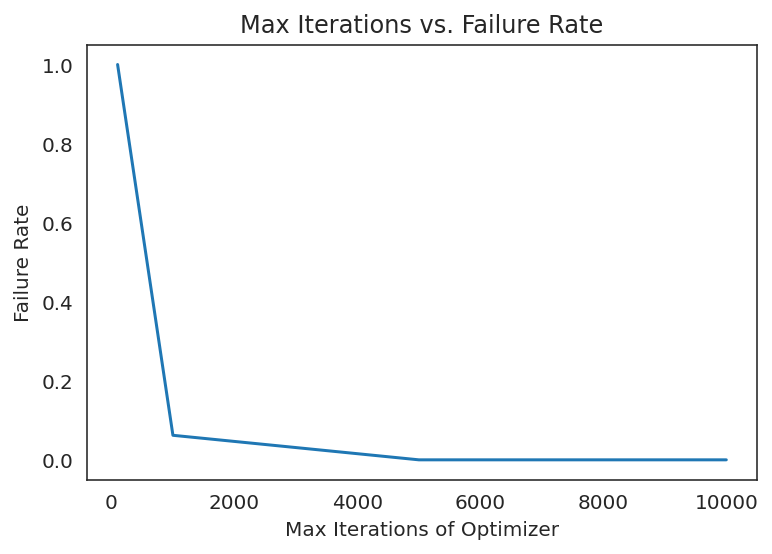

In [34]:
# plot failure rates for different max iters
ax = plt.gca()
ax.set_title('Max Iterations vs. Failure Rate')
ax.set_xlabel('Max Iterations of Optimizer')
ax.set_ylabel('Failure Rate')
sns.lineplot(x=[100, 1000, 5000, 10000], y=failure_rates_1000['0']);

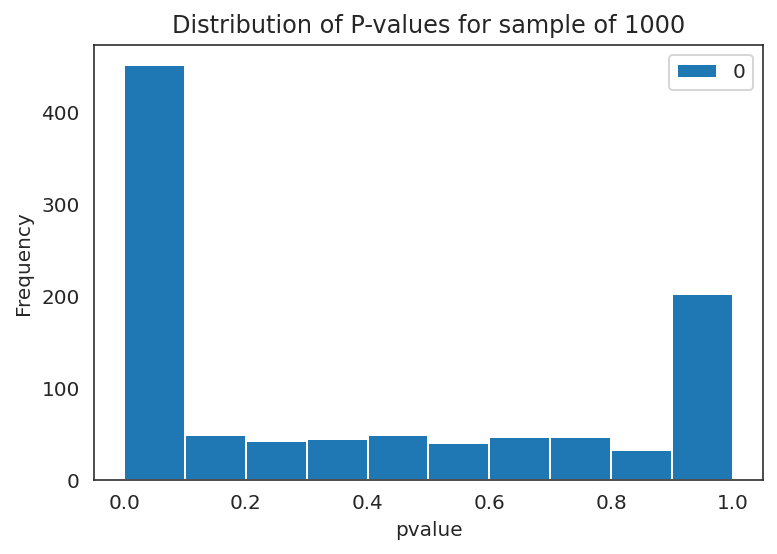

In [39]:
# plot p value distribution for sample size 1000
ax = plt.gca()
ax.set_title('Distribution of P-values for sample of 1000')
ax.set_xlabel('pvalue')
pd.read_csv('./../results/10000_iterations_pvalues_1000.csv').plot(kind='hist', ax=ax);